<a href="https://colab.research.google.com/github/williambjames/personal-projects/blob/master/NBA_Draft_Age.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#As always, the first thing we'll want to do is import our libraries... don't know where I'd be without them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import string
import math

In [2]:
style.use('fivethirtyeight')

Due to some formatting issues stemming from unique characters in players names, we need to specify the 'python' `engine`

In [3]:
draft = pd.read_csv('/content/draft_names.csv',engine='python')

We need to find a way to isolate the player ID (first 5 letters of last name, first 2 letters of first name, and an index of how many players have the same name (first player is assigned 01) I.E. Jayson Tatum is listed as `tatumja01`

APPROACH:
Create a new column in the DataFrame labeled `id`. For each row in the DataFrame, we will take `Player`, convert it to a string (currently an object), and splice the string at the instance of `/`, which is the dividing character between the full name and ID. By splicing at the `/`, we generate an array of the two strings, so we'll take the second string at index 1.

In [4]:
draft['id']=draft['Player'].str.split('/',1).str[1]

In [12]:
draft = draft.rename(columns={'Year':'draft_year','Age':'draft_age'}) #better to be a little more specific by saying draft_year over Year, same with age

#Stats!
Now that we've set up our DataFrame containing draft information, now we need to merge in our advanced stats from BBRef.com into our draft DF.

In [6]:
stats = pd.read_csv('/content/bbref-scraped-full-adv-stats.csv',engine='python')

In [7]:
stats

,id,player,Year,pos,age,team_id,g,mp,per,ts_pct,fg3a_per_fga_pct,fta_per_fga_pct,orb_pct,drb_pct,trb_pct,ast_pct,stl_pct,blk_pct,tov_pct,usg_pct,ws-dum,ows,dws,ws,ws_per_48,bpm-dum,obpm,dbpm,bpm,vorp
0,abdelal01TOT,Alaa Abdelnaby,1995,PF,26,TOT,54,506,12.6,0.519,0.009,0.152,8.7,17.4,13.1,5.0,1.5,1.8,15.4,25.6,NaN,-0.4,0.7,0.3,0.027,NaN,-4.4,0.1,-4.3,-0.3
1,abdelal01SAC,Alaa Abdelnaby,1995,PF,26,SAC,51,476,14.1,0.540,0.009,0.159,8.5,17.3,13.0,5.3,1.6,1.9,14.5,25.7,NaN,-0.1,0.7,0.6,0.058,NaN,-3.6,0.5,-3.1,-0.1
2,abdelal01PHI,Alaa Abdelnaby,1995,PF,26,PHI,3,30,-12.5,0.091,0.000,0.000,11.6,19.6,15.5,0.0,0.0,0.0,31.3,23.8,NaN,-0.3,0.0,-0.3,-0.466,NaN,-17.6,-7.3,-24.9,-0.2
3,abdulma02DEN,Mahmoud Abdul-Rauf,1995,PG,25,DEN,73,2082,17.8,0.543,0.214,0.155,1.9,5.9,3.9,23.0,1.9,0.3,10.0,25.8,NaN,3.8,1.3,5.0,0.115,NaN,2.3,-1.2,1.2,1.7
4,adamsmi01CHH,Michael Adams,1995,PG,32,CHH,29,443,17.7,0.583,0.547,0.203,1.7,5.9,3.9,34.6,2.7,0.2,13.9,19.6,NaN,1.1,0.5,1.6,0.169,NaN,2.5,0.8,3.3,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14847,youngtr01ATL,Trae Young,2020,PG,21,ATL,60,2120,23.9,0.595,0.455,0.448,1.6,11.5,6.5,45.6,1.4,0.3,16.2,34.9,NaN,5.3,0.6,5.9,0.133,NaN,6.2,-2.3,3.9,3.1
14848,zelleco01CHO,Cody Zeller,2020,C,27,CHO,58,1341,18.8,0.576,0.157,0.374,12.6,21.2,16.7,11.3,1.5,1.7,11.9,20.8,NaN,2.3,1.3,3.6,0.129,NaN,0.2,-0.8,-0.6,0.5
14849,zellety01SAS,Tyler Zeller,2020,C,30,SAS,2,4,22.4,0.250,0.000,0.000,80.9,26.9,53.9,0.0,0.0,0.0,0.0,43.2,NaN,0.0,0.0,0.0,-0.075,NaN,-0.3,-22.1,-22.4,0.0
14850,zizican01CLE,Ante �_i�_i��,2020,C,23,CLE,22,221,16.4,0.597,0.000,0.264,9.0,24.4,16.6,4.2,1.5,1.9,11.1,17.5,NaN,0.3,0.2,0.5,0.106,NaN,-1.7,-1.5,-3.2,-0.1


For some reason, the BBRef.com advanced stats page outputs a slightly different id output than the others, where the format this time is 

LAST NAME (5 letters), FIRST NAME (2 letters), NAME FREQUENCY (2 digits, beginning at 01) TEAM CODE (3 letters)
Example: Jayson Tatum is no longer `Tatumja01`, but now is `Tatumja01BOS`

So to match the `id` from the DF `draft`, we'll do a little more string splicing.

-New `id` = Old `id` object converted to string, only accepting the string splice [:-3], meaning it take everything except for the first three letters in reverse order, thus removing all `team_id` from the players `id`.
(BBRef.com only uses three letter team codes.)

In [8]:
stats['id'] = stats['id'].str[:-3]

In [9]:
stats = stats.loc[(stats['Year']>1999)] #Set a few limits, players only drafted in 2000 or later
stats = stats.loc[(stats['mp']>499)] #Seasons must comprise no fewer than 500 minutes played

Merge the columns `id`, `draft_age`, and `draft_year` from the `draft` DataFrame into the `stats` DataFrame, merging on similar `id`

In [13]:
stats = pd.merge(stats, draft[['id','draft_age','draft_year']],on=['id'])

I'm going to apply `np.floor` to players draft ages so instead of something like 21.46 years old, they're listed as 21, for the practicality of grouping by age. I don't think them being 21 years and X days is super significant, I think the years is far more important than holding onto days.

In [15]:
stats['draft_age'] = stats['draft_age'].apply(np.floor)

Let's look at a simple grouping by age of the mean `PER` and `VORP` of players drafted at that age, and `id` will represent the unique `id` values, in other words, how many players have been drafted at that age since 2000.

In [16]:
stats.groupby(['draft_age'],as_index=False).agg({'per':'mean','vorp':'mean','id':'nunique'})

,draft_age,per,vorp,id
0,17.0,19.628571,1.371429,1
1,18.0,15.786019,1.329147,47
2,19.0,15.915426,1.084142,126
3,20.0,14.849005,0.906806,138
4,21.0,14.050272,0.753986,159
5,22.0,13.040232,0.574565,168
6,23.0,12.385417,0.316667,56
7,24.0,12.816279,0.041860,8
8,25.0,7.200000,-0.500000,1


#But hold on! We have more data work to do!
BBRef.com organizes their data so that if a player was traded mid season from team A to team B, his stats will have a row for team A, a row for team B, AND a row for `TOT`, representing his overall season stats. 

I have to go through the data, find the TOT occurences, and remove all rows corresponding to that specific player & season EXCEPT for the `TOT`.

In [17]:
burn = stats

The following will give a us a list of all player `id`'s and `Year`'s in which they were involved with a trade.

In [35]:
tot = stats.loc[(stats['team_id']=='TOT'),['id','Year','team_id']]

In [37]:
tot['label'] = tot['id'] + tot['Year'].astype(str)
burn['label'] = burn['id'] + burn['Year'].astype(str)

find the teams they were on that season by excluding `TOT` from `team_id` results.

In [40]:
trades = burn.loc[(burn['label'].isin(tot.label)) & ~(burn['team_id']=='TOT')]
trades

,id,player,Year,pos,age,team_id,g,mp,per,ts_pct,fg3a_per_fga_pct,fta_per_fga_pct,orb_pct,drb_pct,trb_pct,ast_pct,stl_pct,blk_pct,tov_pct,usg_pct,ws-dum,ows,dws,ws,ws_per_48,bpm-dum,obpm,dbpm,bpm,vorp,draft_age,draft_year,label
1,alexaco02,Courtney Alexander,2001,PG,23,WAS,27,910,14.2,0.519,0.091,0.266,2.8,7.6,5.1,8.6,1.7,0.2,10.9,24.3,NaN,0.9,0.1,0.9,0.048,NaN,-0.8,-2.5,-3.3,-0.3,23.0,2000,alexaco022001
13,crawfja01,Jamal Crawford,2009,PG,28,GSW,54,2087,15.0,0.541,0.372,0.349,1.1,8.1,4.6,17.8,1.1,0.4,11.0,22.6,NaN,2.7,-0.1,2.7,0.061,NaN,1.1,-2.7,-1.6,0.2,20.0,2000,crawfja012009
48,houseed01,Eddie House,2005,PG,26,SAC,50,550,15.7,0.538,0.290,0.065,2.8,9.5,6.2,19.4,1.7,0.4,9.1,19.6,NaN,0.9,0.3,1.2,0.105,NaN,0.9,-0.8,0.1,0.3,22.0,2000,houseed012005
54,houseed01,Eddie House,2010,PG,31,BOS,50,846,11.9,0.527,0.519,0.124,1.0,8.7,5.0,9.2,1.7,0.7,7.4,20.3,NaN,0.4,1.0,1.4,0.081,NaN,-0.4,0.0,-0.4,0.3,22.0,2000,houseed012010
89,masonde01,Desmond Mason,2003,SF,25,SEA,52,1811,14.2,0.490,0.082,0.271,5.6,16.3,10.9,9.3,1.4,0.9,9.0,21.3,NaN,1.5,1.7,3.1,0.083,NaN,-0.6,-0.9,-1.5,0.2,22.0,2000,masonde012003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4736,smithde03,Dennis Smith Jr.,2019,PG,21,DAL,32,908,11.5,0.527,0.350,0.230,2.1,9.3,5.7,24.1,2.1,1.0,20.3,23.3,NaN,-0.7,0.9,0.2,0.010,NaN,-2.1,0.0,-2.1,0.0,19.0,2017,smithde032019
4737,smithde03,Dennis Smith Jr.,2019,PG,21,NYK,21,600,13.5,0.473,0.283,0.253,2.4,7.9,5.1,32.2,2.2,1.3,14.2,27.0,NaN,-0.5,0.3,-0.2,-0.014,NaN,-0.8,-0.9,-1.7,0.0,19.0,2017,smithde032019
4747,wrighde01,Delon Wright,2019,PG,26,TOR,49,897,14.5,0.527,0.307,0.208,4.8,10.1,7.5,16.8,2.5,1.4,10.4,17.1,NaN,1.0,1.3,2.3,0.123,NaN,0.1,1.6,1.7,0.8,23.0,2015,wrighde012019
4748,wrighde01,Delon Wright,2019,PG,26,MEM,26,802,16.6,0.519,0.294,0.336,4.0,15.9,9.9,26.9,2.6,1.8,11.6,19.2,NaN,0.9,1.1,2.0,0.119,NaN,0.0,1.2,1.2,0.6,23.0,2015,wrighde012019


Now lets .loc the players seasons in `trades` out of the stats df.

In [41]:
stats = stats.loc[~(stats['label'].isin(trades.label) & 
                    stats['Year'].isin(trades.Year) & 
                    stats['team_id'].isin(trades.team_id))]

,id,player,Year,pos,age,team_id,g,mp,per,ts_pct,fg3a_per_fga_pct,fta_per_fga_pct,orb_pct,drb_pct,trb_pct,ast_pct,stl_pct,blk_pct,tov_pct,usg_pct,ws-dum,ows,dws,ws,ws_per_48,bpm-dum,obpm,dbpm,bpm,vorp,draft_age,draft_year,label
0,alexaco02,Courtney Alexander,2001,PG,23,TOT,65,1382,11.6,0.484,0.080,0.262,3.5,8.4,5.9,8.0,1.7,0.3,10.5,23.2,NaN,0.3,0.5,0.8,0.027,NaN,-2.4,-1.9,-4.3,-0.8,23.0,2000,alexaco022001
2,alexaco02,Courtney Alexander,2002,SG,24,WAS,56,1325,13.6,0.521,0.038,0.255,3.7,9.3,6.5,11.3,1.4,0.4,10.2,20.4,NaN,1.6,0.6,2.2,0.080,NaN,-0.9,-1.3,-2.2,-0.1,23.0,2000,alexaco022002
3,alexaco02,Courtney Alexander,2003,PG,25,NOH,66,1360,9.3,0.459,0.113,0.289,3.3,6.8,5.0,9.8,1.2,0.3,10.7,21.3,NaN,0.1,1.0,1.1,0.040,NaN,-3.3,-1.2,-4.5,-0.9,23.0,2000,alexaco022003
4,cleavma01,Mateen Cleaves,2001,PG,23,DET,78,1268,9.0,0.458,0.043,0.343,2.2,9.1,5.6,26.8,2.0,0.1,23.2,20.5,NaN,-1.3,1.2,-0.1,-0.006,NaN,-4.5,-0.7,-5.2,-1.0,22.0,2000,cleavma012001
5,crawfja01,Jamal Crawford,2001,PG,20,CHI,61,1050,8.5,0.442,0.385,0.112,1.0,9.4,5.0,23.0,2.2,1.0,21.0,17.9,NaN,-1.3,0.4,-0.9,-0.043,NaN,-2.9,-1.5,-4.4,-0.6,20.0,2000,crawfja012001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4775,zizican01,Ante �_i�_i��,2019,C,22,CLE,59,1082,16.2,0.590,0.000,0.399,10.6,22.8,16.4,7.7,0.6,1.8,13.6,18.2,NaN,1.7,0.3,2.0,0.087,NaN,-1.1,-2.1,-3.2,-0.3,19.0,2016,zizican012019
4776,bradlto01,Tony Bradley,2020,C,22,UTA,58,663,21.7,0.681,0.016,0.243,19.1,25.0,22.2,5.4,1.0,4.1,12.5,15.8,NaN,2.2,1.1,3.3,0.236,NaN,1.0,0.3,1.3,0.6,19.0,2017,bradlto012020
4777,fultzma01,Markelle Fultz,2020,PG,21,ORL,72,1996,14.3,0.517,0.175,0.206,2.1,11.0,6.4,29.0,2.2,0.5,14.9,21.4,NaN,0.6,2.0,2.7,0.065,NaN,-1.8,0.0,-1.8,0.1,19.0,2017,fultzma012020
4778,jonesda03,Damian Jones,2020,C,24,ATL,55,887,15.6,0.712,0.051,0.472,8.9,16.2,12.5,5.6,1.4,3.8,11.5,11.4,NaN,2.2,0.6,2.8,0.152,NaN,-1.6,0.1,-1.5,0.1,20.0,2016,jonesda032020


#Almost Done!

I want to add another filter, this one is a seasons played filter. I decided if a player completed 3 or more seasons consisting of 500+ minutes each, they will be included in the dataset.

So now we group by player ID and count the eligible years played.

In [42]:
player = stats.groupby('id',as_index=False).agg({'Year':'count'})
player

,id,Year
0,abrinal01,3
1,acyqu01,7
2,adamsst01,7
3,adebaba01,3
4,afflaar01,13
...,...,...
699,zelleco01,7
700,zellety01,7
701,zipsepa01,2
702,zizican01,1


In [43]:
player = player.loc[(player['Year']>2)]

Lets circle back around and apply the filtered list of players back into `stats`

In [46]:
stats = stats.loc[(stats['id'].isin(player.id))]

I want to keep track of experience in the league since this is analysis of players over N seasons.
Taking the `Year` and subtracting the `draft_year` will show us that is their Nth season, but I would like to maintain the consistency with professional sports leagues by labeling this as experience, so a Rookie will have 0 experience, or N seasons = 0, as opposed to 1. So the final equation will be:

In [47]:
stats['exp'] = stats['Year'] - stats['draft_year'] - 1

Now we finally have everything ready to go! Lets export just a few data points into a new DataFrame, one we'll fittingly call... `df`.


In [50]:
df = stats.groupby(['draft_age','exp'],as_index=False).agg({'per':'mean','vorp':'mean','bpm':'mean','ws_per_48':'mean'})

In [51]:
df

,draft_age,exp,per,vorp,bpm,ws_per_48
0,17.0,1,15.400000,0.500000,-1.000000,0.112000
1,17.0,2,22.600000,1.600000,4.200000,0.230000
2,17.0,3,20.000000,1.100000,1.100000,0.184000
3,17.0,4,20.200000,1.800000,1.500000,0.188000
4,17.0,5,21.100000,2.000000,3.200000,0.210000
...,...,...,...,...,...,...
114,24.0,6,13.933333,0.300000,-1.500000,0.101000
115,24.0,7,14.000000,-0.033333,-2.133333,0.081667
116,24.0,8,15.400000,1.000000,-0.500000,0.126000
117,24.0,9,17.800000,0.800000,-0.100000,0.144000


I want to write a function that will let me type in any of the possible metrics included in `df` (i.e. `per`,`vorp`,`bpm`, and `ws_per_48`) and it will plot a Seaborn `lmplot` and fill in the remainder of minutia (title, axis) on its own from the argument passed.

In [85]:
def plot(y2,data):
  _df = df.dropna(subset=[y2]) 
  sns.lmplot(x='exp',y=y2,data=_df.loc[(_df['draft_age'].isin([18,19,20,21,22]))],scatter=False,order=3,ci=False,hue='draft_age',height=5,aspect=1,legend=False)
  plt.title('Draft Age vs. ' + y2.upper() +  ' Over N Seasons')
  plt.xlabel('Experience')
  plt.ylabel(y2.upper())
  plt.legend(title='Age Drafted')
  plt.show()

And there you go! Here's a look at the final results.

It definitely appears that drafting teens has both opportunity for faster development as well as longer term success relative to those drafted in 20's

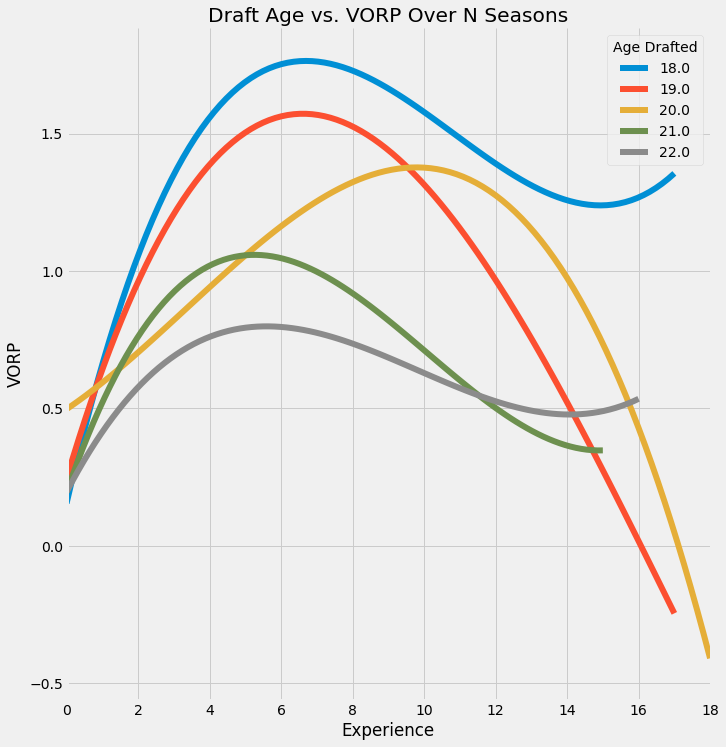

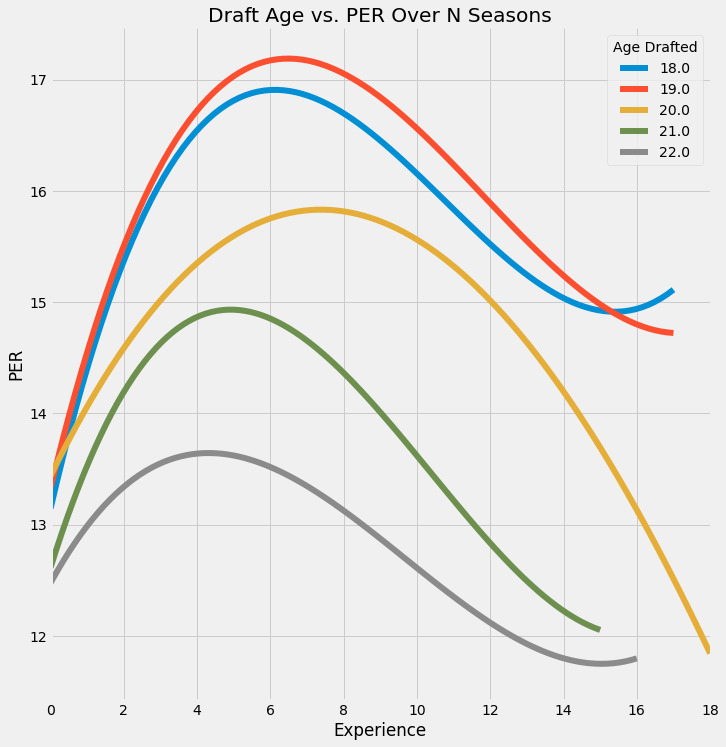

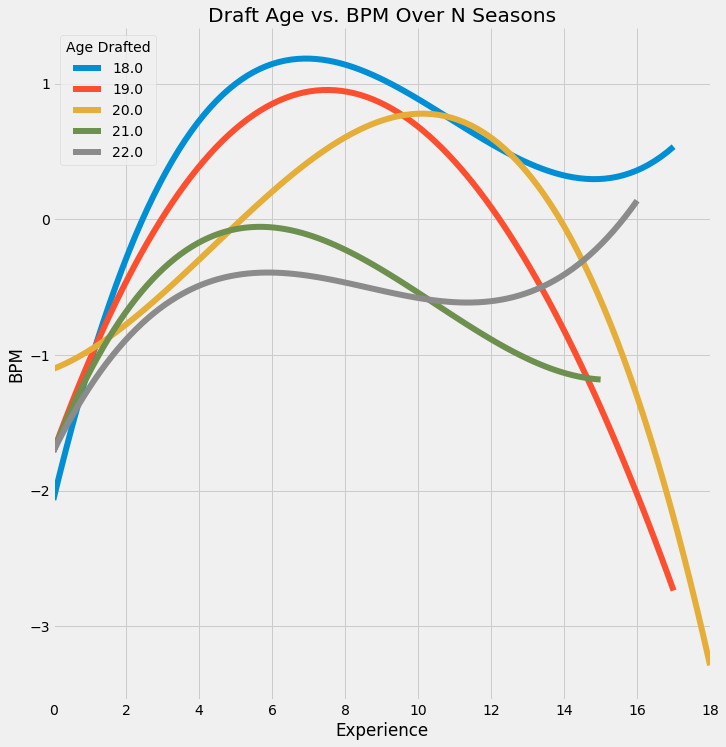

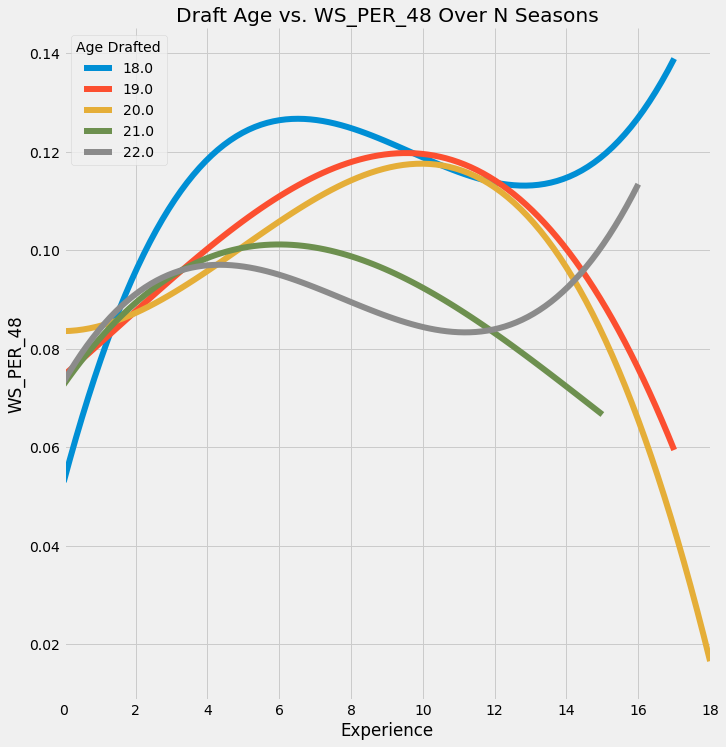

In [87]:
plot('vorp',df)
plot('per',df)
plot('bpm',df)
plot('ws_per_48',df)